In [1]:
!pip install xgboost

## XGBoost for Time-series Analysis

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
import xgboost
from xgboost import XGBRegressor
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [4]:
# load dataset
series = read_csv('combined_data_with_survival.csv')

In [5]:
series

,PatientID,Timestamp,HR,RespRate,In-hospital_death
0,132543,0.00,74.0,17.0,0
1,132543,0.01,74.0,17.0,0
2,132543,0.02,74.0,17.0,0
3,132543,0.03,74.0,17.0,0
4,132543,0.04,74.0,17.0,0
...,...,...,...,...,...
771661,142654,28.96,63.0,16.0,0
771662,142654,28.97,63.0,16.0,0
771663,142654,28.98,63.0,16.0,0
771664,142654,28.99,63.0,16.0,0


In [6]:
# list of patients
patients = list(series['PatientID'].unique())

In [7]:
# Number of patients
print(len(list(series['PatientID'].unique())))

266


In [8]:
# Number of datapoints per patient
print(series.groupby('PatientID').size().reset_index(name='NumDatapoints'))

     PatientID  NumDatapoints
0       132543           2901
1       132554           2901
2       132577           2901
3       132597           2901
4       132703           2901
..         ...            ...
261     142500           2901
262     142573           2901
263     142580           2901
264     142621           2901
265     142654           2901

[266 rows x 2 columns]


In [9]:
series['Timestamp'] = series.groupby('PatientID')['Timestamp'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 2900 + 1)

In [10]:
series

,PatientID,Timestamp,HR,RespRate,In-hospital_death
0,132543,1.0,74.0,17.0,0
1,132543,2.0,74.0,17.0,0
2,132543,3.0,74.0,17.0,0
3,132543,4.0,74.0,17.0,0
4,132543,5.0,74.0,17.0,0
...,...,...,...,...,...
771661,142654,2897.0,63.0,16.0,0
771662,142654,2898.0,63.0,16.0,0
771663,142654,2899.0,63.0,16.0,0
771664,142654,2900.0,63.0,16.0,0


### Heart Rate

In [80]:
values = series.groupby('PatientID')['HR'].apply(list).apply(list).tolist()

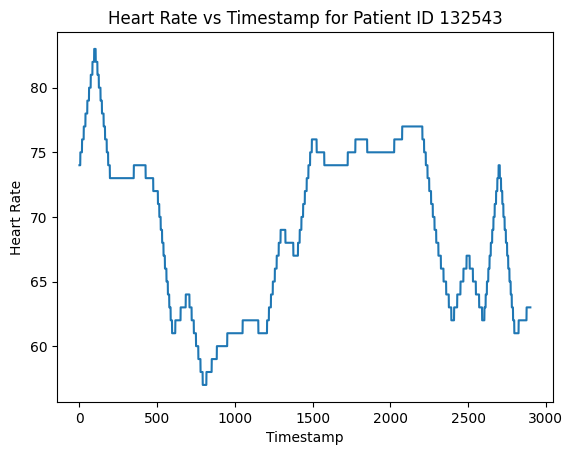

In [81]:
# plot dataset
pyplot.title("Heart Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Heart Rate")
pyplot.plot(values[0])
pyplot.show()

In [82]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

#### For 5 patients

In [62]:
random.seed(80)
random_patients = [random.randint(0, len(patients)) for _ in range(5)]
# # random_patients = [136538, 137431, 141592, 138316, 134551]

In [83]:
pids = [(patients[idx]) for idx in random_patients]
pids

[138022, 140414, 141015, 139791, 139739]

In [84]:
random_patients

[139, 201, 215, 188, 186]

In [85]:
total_error=[]
all_predictions=[]

In [86]:
for idx in random_patients:
  # transform the time series data into supervised learning
  data = series_to_supervised(values[idx], n_in=100, n_out=100)
  # Split the data into training and testing sets
  train, test = train_test_split(data, 100)

  # Perform walk-forward validation and get predictions
  error, test, predictions = walk_forward_validation(data, 100)
  all_predictions.append(predictions)
  total_error.append(error)

In [87]:
print("Average mean average error across all patients = ", sum(total_error)/len(total_error))

Average mean average error across all patients =  0.07232522583007812


In [96]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 100 or pred < 60 else None for pred in predictions]

    timesteps = np.arange(2902, 3002)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Heart Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Heart Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

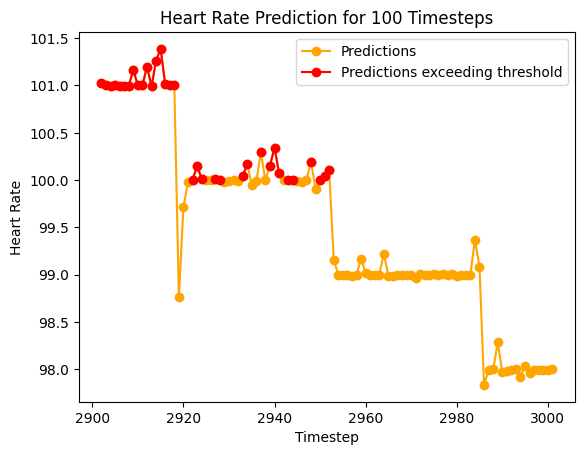

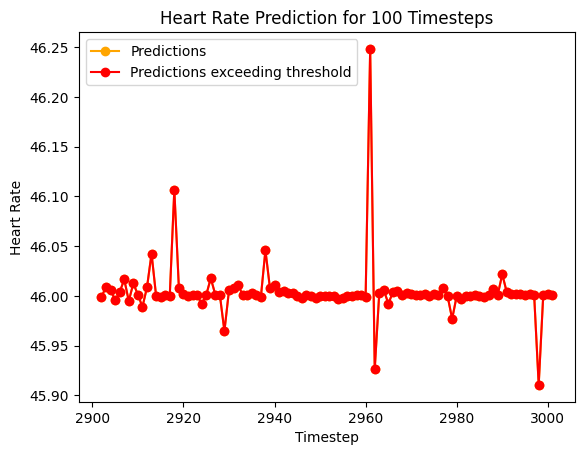

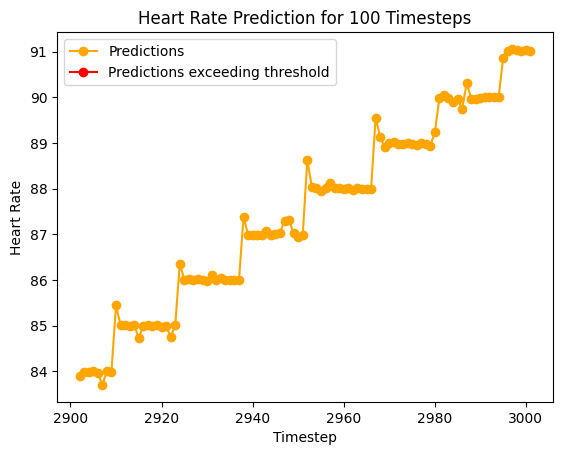

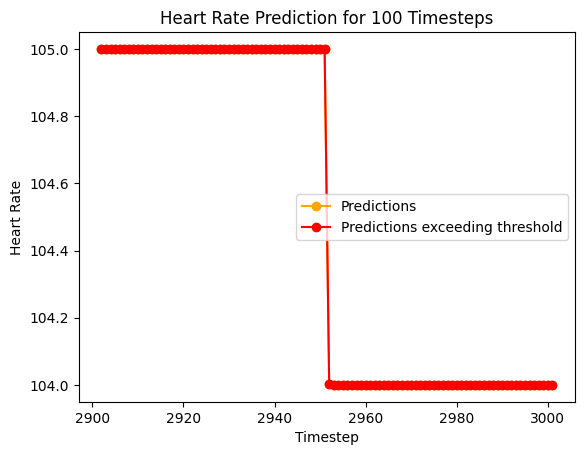

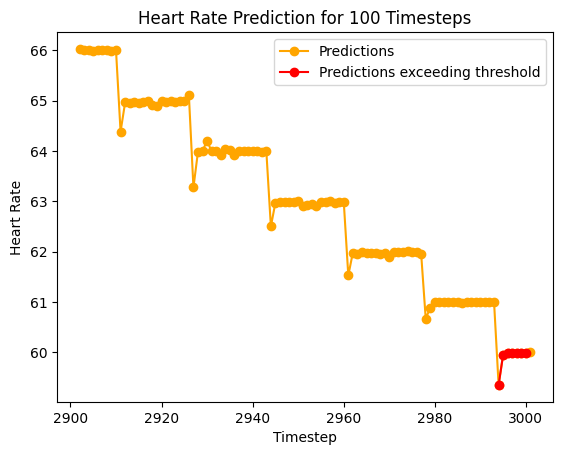

In [97]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

Plot all values for patients to assess continuation in trends

In [93]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['HR'])
  return values

In [94]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 60 or above 100 in red
    threshold_low = 60
    threshold_high = 100
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [102]:
all_values=[]

Plotting for patient ID: 138022


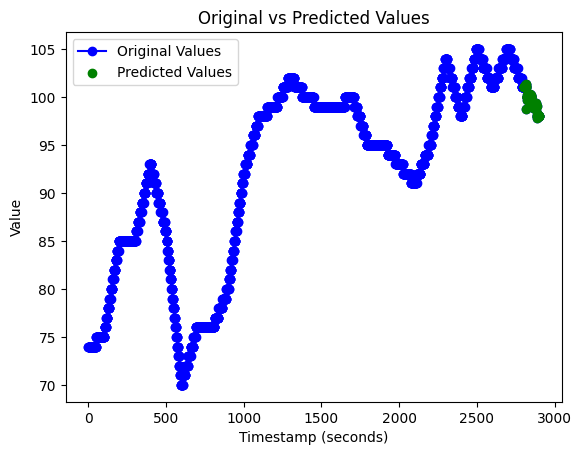

Plotting for patient ID: 140414


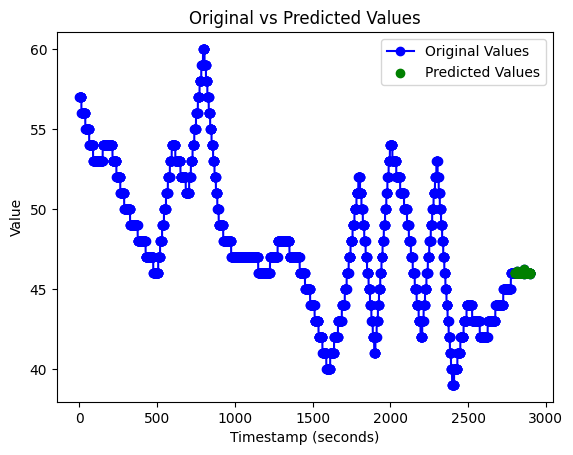

Plotting for patient ID: 141015


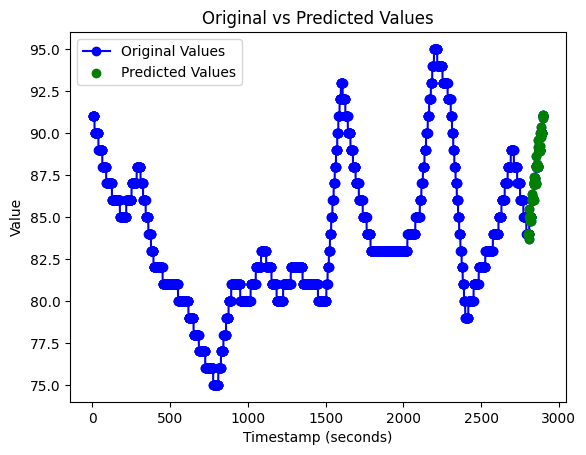

Plotting for patient ID: 139791


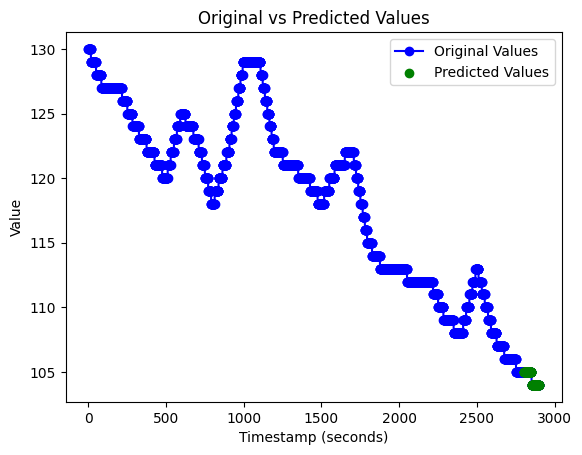

Plotting for patient ID: 139739


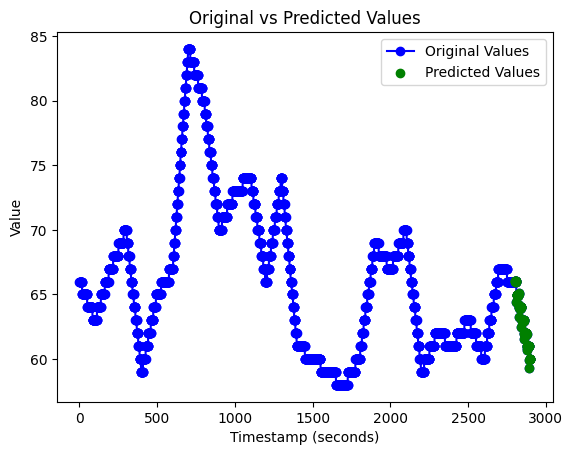

In [103]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [106]:
result_df = pd.DataFrame({'PatientID': [p for p, values in zip(pids, all_values) for _ in range(len(values))],
                   'HR': [val for values in all_values for val in values]})

In [107]:
result_df

,PatientID,HR
0,138022,74.000000
1,138022,74.000000
2,138022,74.000000
3,138022,74.000000
4,138022,74.000000
...,...,...
14500,139739,59.977093
14501,139739,59.992104
14502,139739,59.991451
14503,139739,59.990582


### Respiratory Rate

In [108]:
values = series.groupby('PatientID')['RespRate'].apply(list).apply(list).tolist()

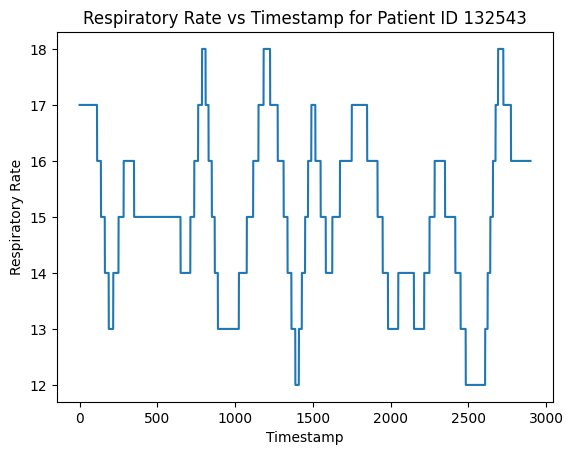

In [109]:
# plot dataset
pyplot.title("Respiratory Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Respiratory Rate")
pyplot.plot(values[0])
pyplot.show()

In [110]:
total_error=[]
all_predictions=[]

In [111]:
for idx in random_patients:
  # transform the time series data into supervised learning
  data = series_to_supervised(values[idx], n_in=100, n_out=100)
  # Split the data into training and testing sets
  train, test = train_test_split(data, 100)

  # Perform walk-forward validation and get predictions
  error, test, predictions = walk_forward_validation(data, 100)
  all_predictions.append(predictions)
  total_error.append(error)

In [112]:
print("Average mean average error across all patients = ", sum(total_error)/len(total_error))

Average mean average error across all patients =  0.05072060966491698


In [127]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 20 or pred < 12 else None for pred in predictions]

    timesteps = np.arange(2902, 3002)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Respiratory Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Respiratory Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

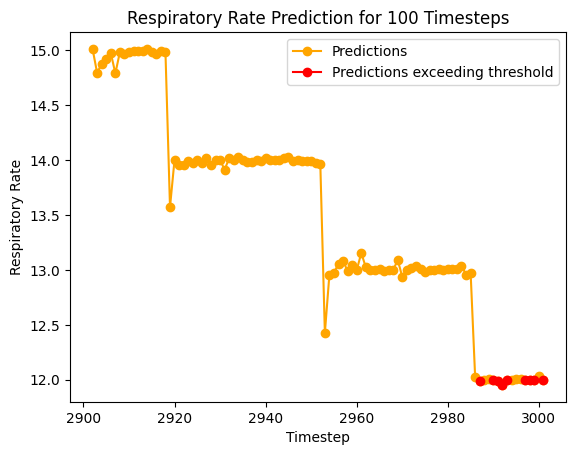

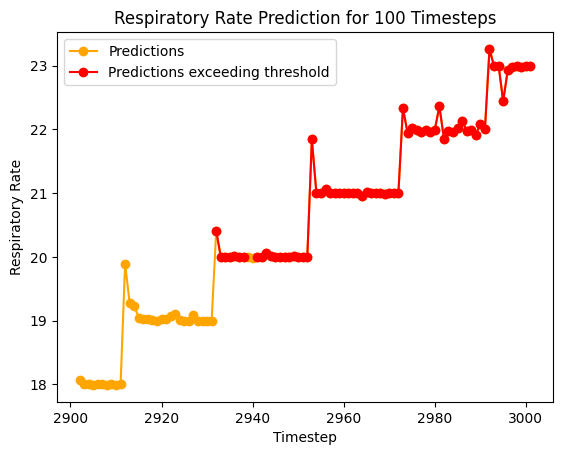

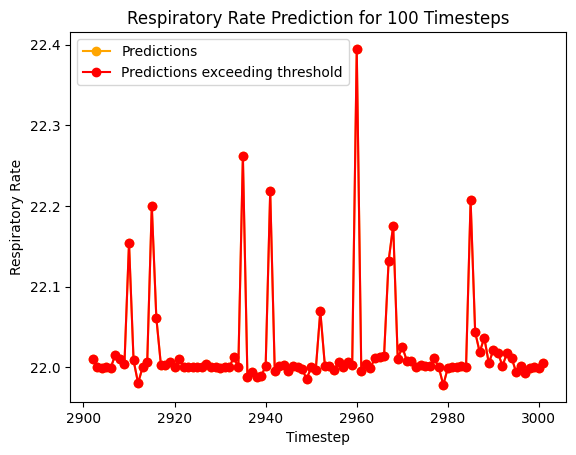

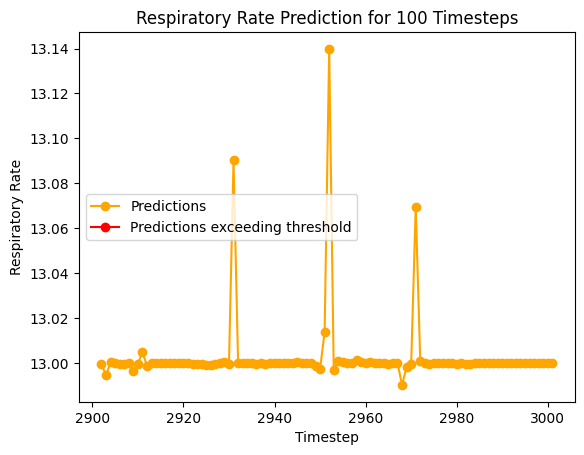

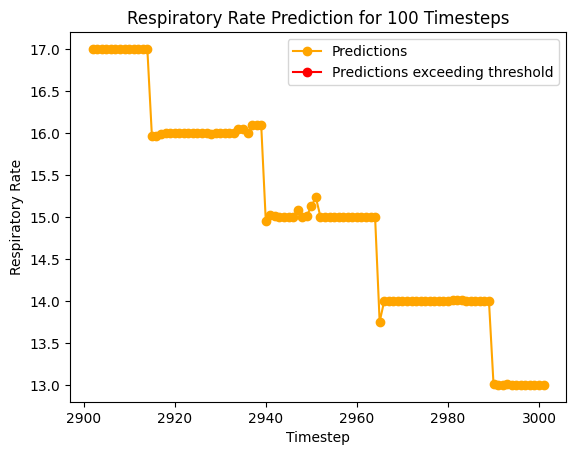

In [128]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

Plot all values for patients to assess continuation in trends

In [119]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['RespRate'])
  return values

In [120]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 12 or above 20 in red
    threshold_low = 12
    threshold_high = 20
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [121]:
all_resp_values=[]

Plotting for patient ID: 138022


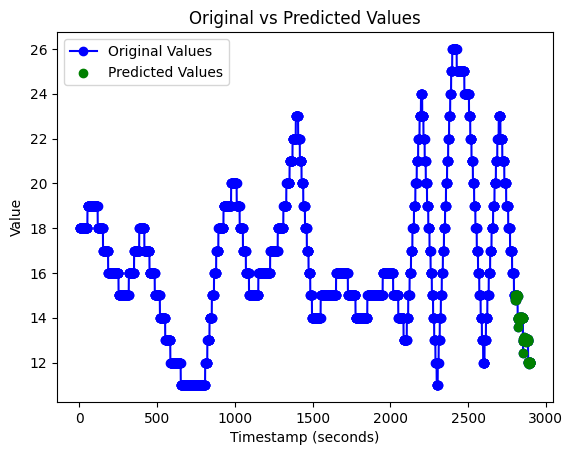

Plotting for patient ID: 140414


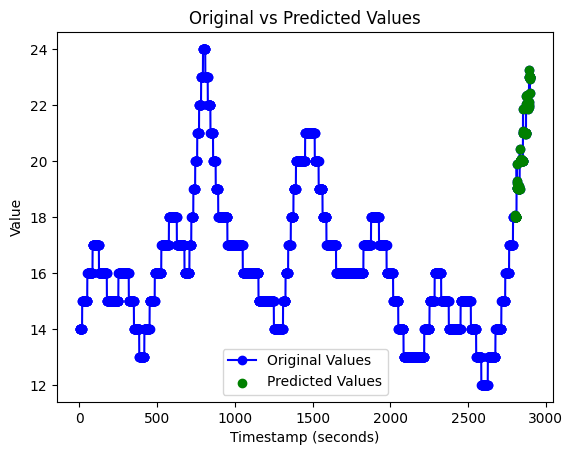

Plotting for patient ID: 141015


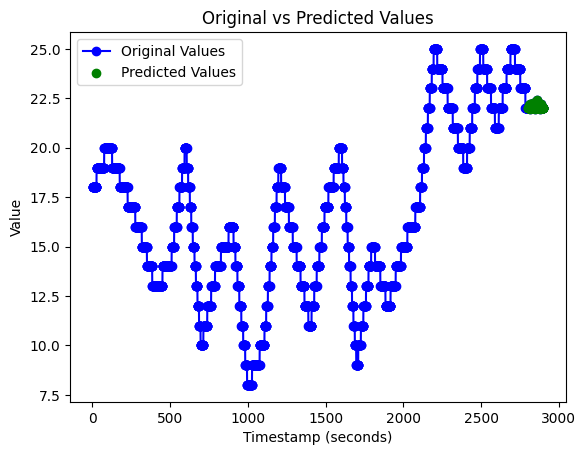

Plotting for patient ID: 139791


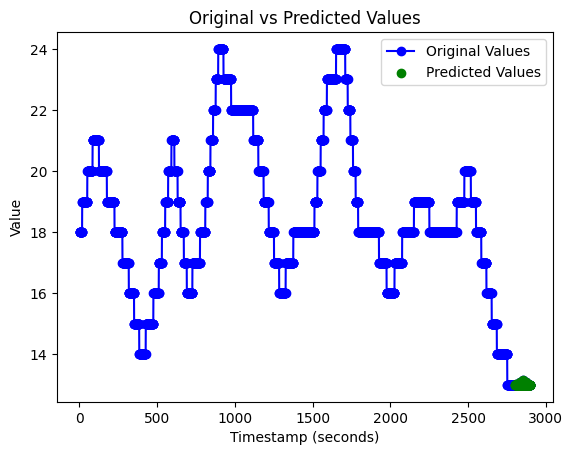

Plotting for patient ID: 139739


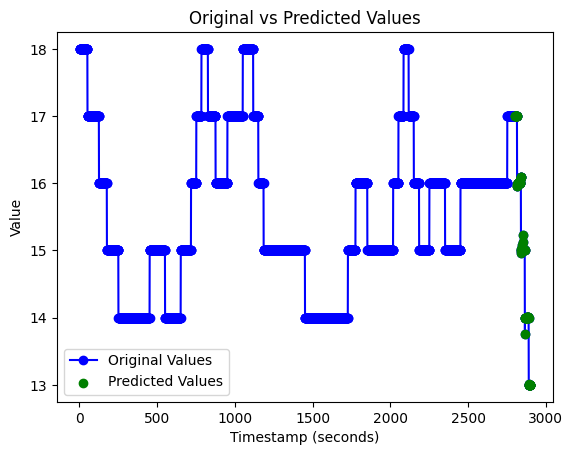

In [122]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_resp_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [129]:
all_resp = [val for values in all_resp_values for val in values]
result_df['RespRate'] = all_resp

In [130]:
result_df

,PatientID,HR,RespRate
0,138022,74.000000,18.000000
1,138022,74.000000,18.000000
2,138022,74.000000,18.000000
3,138022,74.000000,18.000000
4,138022,74.000000,18.000000
...,...,...,...
14500,139739,59.977093,12.999976
14501,139739,59.992104,12.999784
14502,139739,59.991451,12.999937
14503,139739,59.990582,12.999841


In [131]:
df=result_df.copy()

In [132]:
df['Timestamp'] = df.groupby('PatientID').cumcount() + 1

In [133]:
df

,PatientID,HR,RespRate,Timestamp
0,138022,74.000000,18.000000,1
1,138022,74.000000,18.000000,2
2,138022,74.000000,18.000000,3
3,138022,74.000000,18.000000,4
4,138022,74.000000,18.000000,5
...,...,...,...,...
14500,139739,59.977093,12.999976,2897
14501,139739,59.992104,12.999784,2898
14502,139739,59.991451,12.999937,2899
14503,139739,59.990582,12.999841,2900


In [134]:
df.to_csv('xgboost_results.csv', index=False)